# Bulk RNA Deconvolution

In [ ]:
import sys
import importlib
from tqdm import tqdm, trange
sys.path.append("../src")

import pseudobulk
importlib.reload(pseudobulk)

<module 'pseudobulk' from '/home/jhaberbe/Projects/Personal/bulk-deconvolution/notebook/../src/pseudobulk.py'>

# Generating Pseudobulk Training Data

In [ ]:
import scanpy as sc

adata = sc.read_h5ad("/home/jhaberbe/Projects/Personal/bulk-deconvolution/data/hypothalamus.h5ad")
adata.layers["counts"] = adata.raw.X.copy()

adata = adata[:, adata.X.sum(axis=0) > 1000]

pbulk = pseudobulk.PseudoBulkGenerator(
    adata,
    min_cells=500,
    max_cells=2000,
    alpha=0.5,
    random_state=42069
).generate(n_iterations=10_000)

pbulk.write_h5ad("/home/jhaberbe/Projects/Personal/bulk-deconvolution/data/pbulk.h5ad")

# Initial Estimate of Negative Binomial Distributions.

In [1]:
import scanpy as sc

pbulk = sc.read_h5ad(
    "/home/jhaberbe/Projects/Personal/bulk-deconvolution/data/pbulk.h5ad"
)

In [2]:
sc.pp.highly_variable_genes(pbulk, flavor="seurat_v3", subset=True)

In [3]:
import pandas as pd
from tqdm import tqdm

import torch
from torch import nn
from torch.distributions import NegativeBinomial

class NegativeBinomialModel(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.log_mu = nn.Parameter(torch.zeros(n_features))
        self.log_theta = nn.Parameter(torch.zeros(n_features))

    def log_likelihood(self, counts, standard_size=100):
        log_size_factors = (counts.sum(dim=1) / standard_size).log()
        logits = self.log_mu + log_size_factors.unsqueeze(1)

        nb = NegativeBinomial(
            total_count=self.log_theta.exp(),
            logits=logits
        )

        log_prob = nb.log_prob(counts)

        return log_prob.sum()

class CellTypeMixture:

    def __init__(self, n_features):
        self.model = NegativeBinomialModel(n_features)
    
    def estimate_distribution(self, X, device = "cuda"):
        # Suppose X is (n_samples, n_features)
        X = torch.tensor(X).to(device)

        self.model = NegativeBinomialModel(X.shape[1]).to(device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.1)

        n_epochs = 100
        for epoch in range(n_epochs):
            optimizer.zero_grad()

            log_prob = self.model.log_likelihood(X)  # shape (n_samples, n_features)
            loss = -log_prob.mean()  # negative log-likelihood (we minimize)

            loss.backward()
            optimizer.step()

        return self.model.log_mu, self.model.log_theta

log_mu_cell_type = {}
log_theta_cell_type = {}

for cell_type in tqdm(pbulk.layers):
    X = torch.tensor(pbulk.layers[cell_type])
    ctm = CellTypeMixture(X.shape[1])
    log_mu, log_theta = ctm.estimate_distribution(X[X.sum(dim=1) > 100])

    log_mu_cell_type[cell_type] = log_mu
    log_theta_cell_type[cell_type] = log_theta

pd.DataFrame({
    k: v.cpu().detach().numpy()
    for k, v in log_mu_cell_type.items()
}).to_csv("log_mu.csv")

pd.DataFrame({
    k: v.cpu().detach().numpy()
    for k, v in log_theta_cell_type.items()
}).to_csv("log_theta.csv")

  0%|          | 0/8 [00:00<?, ?it/s]/tmp/ipykernel_1522910/2411076252.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).to(device)
 12%|█▎        | 1/8 [00:01<00:10,  1.47s/it]/tmp/ipykernel_1522910/2411076252.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).to(device)
100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


In [4]:
log_mu_cell_type = {k: v.detach() for k, v in log_mu_cell_type.items()}
log_theta_cell_type = {k: v.detach() for k, v in log_theta_cell_type.items()}

log_mus = torch.stack(list(log_mu_cell_type.values()))
log_thetas = torch.stack(list(log_theta_cell_type.values()))

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import NegativeBinomial, Categorical, MixtureSameFamily

In [7]:
X = torch.tensor((pbulk.X / pbulk.X.mean())).log()
y = torch.tensor((pbulk.obs.values) / (pbulk.obs.values).sum())

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import NegativeBinomial, Categorical, MixtureSameFamily

class NBMixturePredictor(nn.Module):
    def __init__(self, log_mus: torch.Tensor, log_thetas: torch.Tensor, hidden_dim: int = 32):
        """
        Args:
            log_mus: Tensor[C, F] - base log-means per component and feature
            log_thetas: Tensor[C, F] - base log-dispersions per component and feature
            hidden_dim: int - hidden dimension for MLP
        """
        super().__init__()
        self.C, self.F = log_mus.shape
        
        # Register base component parameters (not learnable)
        self.register_buffer("log_mus", log_mus)
        self.register_buffer("log_thetas", log_thetas)

        # Simple MLP to predict mixture weights per sample
        self.mlp = nn.Sequential(
            nn.Linear(self.F, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.C)
        )

    def forward(self, X: torch.Tensor, X_raw: torch.Tensor = None):
        """
        Args:
            X: Tensor[n, F] - observed normalized counts
            X_raw: Tensor[n, F] - raw counts used for size adjustment (optional)
        
        Returns:
            loss: scalar tensor (negative log-likelihood)
        """
        n = X.shape[0]

        # Predict mixture weights per sample
        logits = self.mlp(X)  # [n, C]
        weights = F.softmax(logits, dim=1)  # [n, C]

        # Expand fixed component parameters
        log_mus = self.log_mus.unsqueeze(0)  # [1, C, F]
        log_thetas = self.log_thetas.unsqueeze(0)  # [1, C, F]

        # Optional: apply sample-specific size factors from raw counts
        if X_raw is not None:
            size_factors = (X_raw.sum(dim=1) / 100).clamp(min=1e-6).log()  # [n]
            size_factors = size_factors.unsqueeze(1).unsqueeze(2)  # [n, 1, 1]
        else:
            size_factors = 0.0  # scalar broadcast

        # Compute shifted logits for each [n, C, F]
        shifted_logits = log_mus + size_factors  # [n, C, F]
        theta = log_thetas.exp()  # [1, C, F]

        # Build NB component distribution
        nb = NegativeBinomial(
            total_count=theta.expand(n, -1, -1),
            logits=shifted_logits.expand(n, -1, -1)
        )  # batch_shape=[n, C], event_shape=[F]

        # MixtureSameFamily requires a Categorical with batch_shape=[n], probs=[n, C]
        cat = Categorical(probs=weights)  # [n]

        mixture = MixtureSameFamily(
            mixture_distribution=cat,
            component_distribution=nb
        )  # mixture over C components for each sample

        # Compute log prob for each sample
        log_prob = mixture.log_prob(X)  # shape [n]

        return -log_prob.sum()  # total loss over batch


In [9]:
def scanpy_log_normalize(X: torch.Tensor, target_sum: float = 1e4):
    """
    Scanpy-style log-normalization:
    1. Normalize each row to target_sum (e.g., 10,000)
    2. Apply log1p (i.e., log(1 + x))

    Args:
        X: Tensor[n, F] - raw count matrix
        target_sum: float - normalization target per row (default: 1e4)

    Returns:
        Tensor[n, F] - log-normalized matrix
    """
    row_sums = X.sum(dim=1, keepdim=True).clamp(min=1e-8)   # avoid divide-by-zero
    X_norm = X / row_sums * target_sum
    return torch.log1p(X_norm)

X = scanpy_log_normalize(torch.tensor(pbulk.X))

class MixturePrediction(nn.Module):

    def __init__(self, X, y, hidden_dim=256):
        super(MixturePrediction, self).__init__()

        self.mlp = nn.Sequential(
            nn.Linear(X.shape[1], hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, y.shape[1])
        )

    def forward(self, X):
        logits = self.mlp(X)
        return F.softmax(logits)

model = MixturePrediction(X, y)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.model_selection import train_test_split


def scanpy_log_normalize(X: torch.Tensor, target_sum: float = 1e4):
    row_sums = X.sum(dim=1, keepdim=True).clamp(min=1e-8)
    X_norm = X / row_sums * target_sum
    return torch.log1p(X_norm)


# --- Data setup ---
X_raw = torch.tensor(pbulk.X, dtype=torch.float32)  # (n, F), convert from sparse
y = torch.tensor(pbulk.obs.values, dtype=torch.float32)
y = y / y.sum(dim=1, keepdim=True).clamp(min=1e-8)  # Normalize rows

X = scanpy_log_normalize(X_raw)

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# --- Model definition ---
class MixturePrediction(nn.Module):
    def __init__(self, X, y, hidden_dim=256):
        super(MixturePrediction, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(X.shape[1], hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, y.shape[1])
        )

    def forward(self, X):
        logits = self.mlp(X)
        return F.softmax(logits, dim=-1)

model = MixturePrediction(X, y)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# --- Training loop ---
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = F.kl_div(preds.log(), yb, reduction='batchmean')
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Evaluate on test
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for xb, yb in test_loader:
            preds = model(xb)
            test_loss += F.kl_div(preds.log(), yb, reduction='batchmean').item()

    print(f"Epoch {epoch:02d} | Train Loss: {total_loss:.4f} | Test Loss: {test_loss:.4f}")

Epoch 00 | Train Loss: 41.3286 | Test Loss: 2.0614
Epoch 01 | Train Loss: 12.2928 | Test Loss: 1.2785
Epoch 02 | Train Loss: 8.5120 | Test Loss: 0.9751
Epoch 03 | Train Loss: 6.5212 | Test Loss: 0.7484
Epoch 04 | Train Loss: 5.2059 | Test Loss: 0.5810
Epoch 05 | Train Loss: 4.6166 | Test Loss: 0.5458
Epoch 06 | Train Loss: 4.2513 | Test Loss: 0.5184
Epoch 07 | Train Loss: 3.7404 | Test Loss: 0.4844
Epoch 08 | Train Loss: 3.6979 | Test Loss: 0.4449
Epoch 09 | Train Loss: 3.4081 | Test Loss: 0.4271
Epoch 10 | Train Loss: 3.4142 | Test Loss: 0.4299
Epoch 11 | Train Loss: 3.1842 | Test Loss: 0.5607
Epoch 12 | Train Loss: 3.2272 | Test Loss: 0.4279
Epoch 13 | Train Loss: 3.0909 | Test Loss: 0.3653
Epoch 14 | Train Loss: 3.0368 | Test Loss: 0.3822
Epoch 15 | Train Loss: 2.9963 | Test Loss: 0.4276
Epoch 16 | Train Loss: 2.9614 | Test Loss: 0.3983
Epoch 17 | Train Loss: 2.8623 | Test Loss: 0.4455
Epoch 18 | Train Loss: 2.8258 | Test Loss: 0.3592
Epoch 19 | Train Loss: 2.7824 | Test Loss: 0.401

IndexError: index 8 is out of bounds for axis 1 with size 8

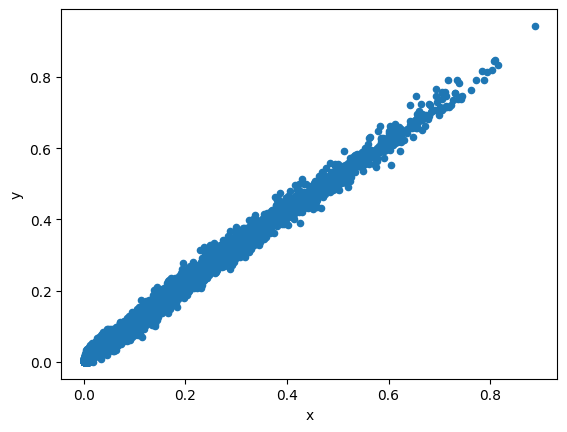

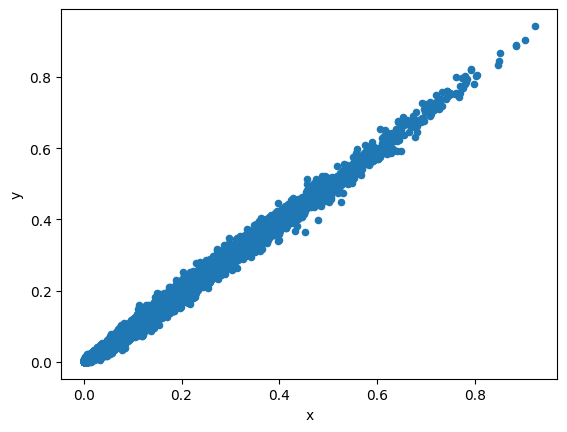

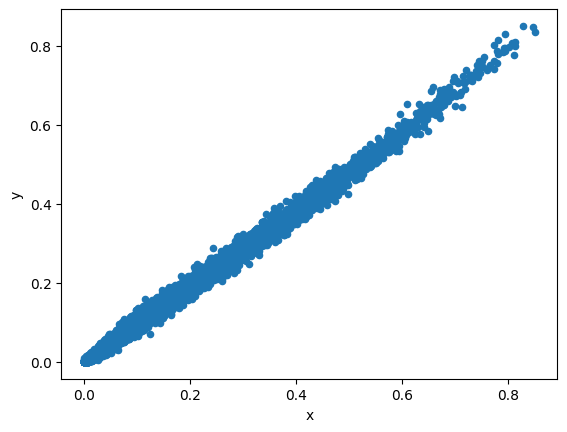

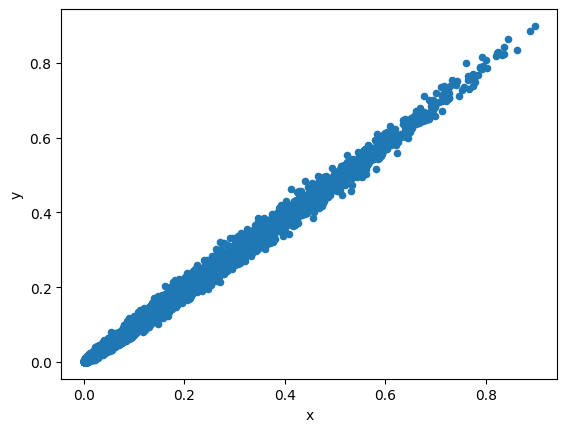

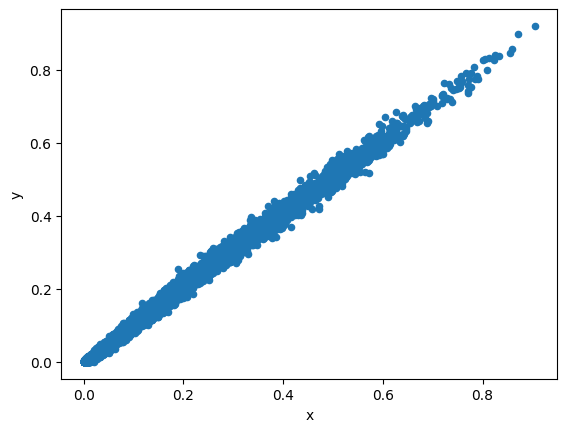

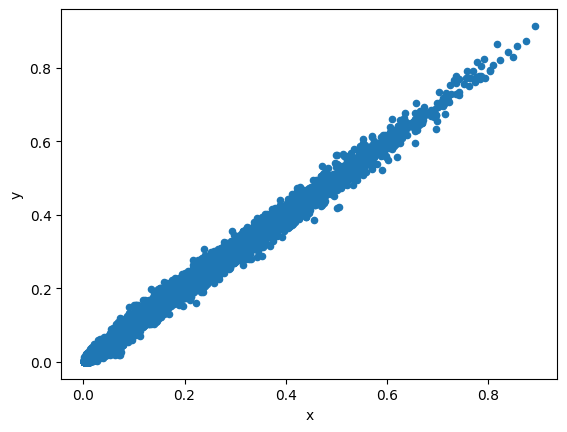

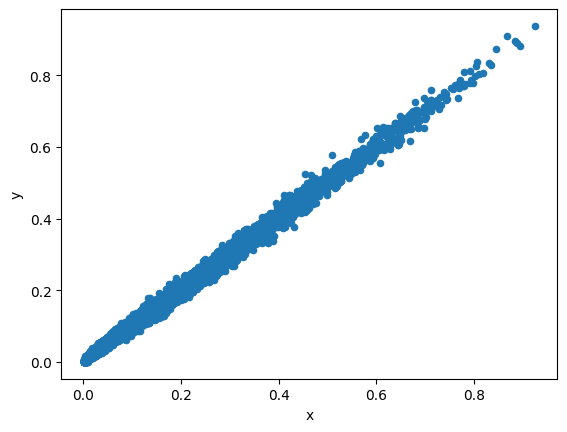

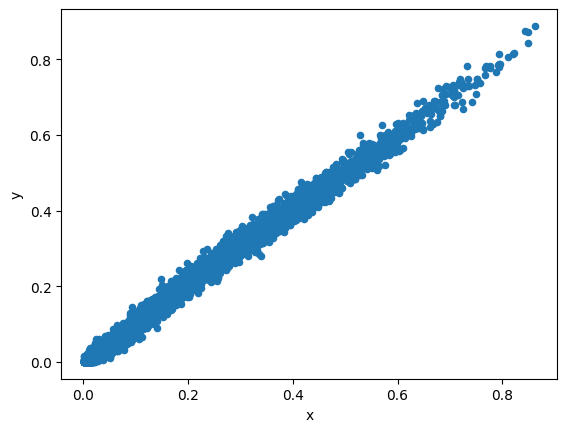

In [ ]:
for i in range(X_test.shape[1]):
    pd.DataFrame({
        "x": model(X).detach().cpu().numpy()[:, i],
        "y": y.detach().cpu().numpy()[:, i]
    }).plot.scatter("x", "y")

In [14]:
mixture_weights = model(X)
mixture_weights = mixture_weights.detach()

In [16]:
import torch
import numpy as np

# counts shape: [num_layers, n_samples, n_features]
counts = torch.tensor(np.stack([pbulk.layers[layer] for layer in pbulk.layers]))  # e.g. [C, n, F]

# Swap axes to [n_samples, num_layers, n_features] for easier normalization per sample and feature
counts = counts.permute(1, 0, 2)  # now shape: [n, C, F]

# Sum over components/layers per sample and feature: shape [n, 1, F]
component_sums = counts.sum(dim=1, keepdim=True).clamp(min=1e-8)  # avoid divide-by-zero

# Normalize counts across components per sample and feature
normalized_counts = counts / component_sums  # shape: [n, C, F], sums to 1 over dim=1

# normalized_counts[n, :, f].sum() == 1 for every n,f

In [376]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MixtureToFeatureDist(nn.Module):
    def __init__(self, num_components, num_features, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(num_components, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_components * num_features)

        self.num_components = num_components
        self.num_features = num_features

    def forward(self, mixture_weights):
        """
        Args:
            mixture_weights: Tensor[n, C] (input mixture weights per sample)
        Returns:
            Tensor[n, C, F] (predicted distributions normalized over components per feature)
        """
        x = F.relu(self.fc1(mixture_weights))             # [n, hidden_dim]
        x = self.fc2(x)                                   # [n, C*F]
        x = x.view(-1, self.num_components, self.num_features)  # [n, C, F]

        # Normalize over components for each sample and feature: sum_c = 1
        x = F.softmax(x, dim=1)  # softmax over component dimension

        return x

n = mixture_weights.shape[0]
num_features = X.shape[1]  # or however you get the number of features
num_components = C         # number of components

model = MixtureToFeatureDist(num_components=num_components, num_features=num_features).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Assume:
# mixture_weights: [n, C] predicted mixture weights from your previous model
# normalized_counts: [n, C, F] true normalized feature distributions across components

for epoch in range(10_000):
    optimizer.zero_grad()
    pred_dist = model(mixture_weights)  # [n, C, F]

    # Compute KL divergence per sample and feature, then mean over batch
    # Flatten last two dims: [n, C, F] -> [n, C*F]
    pred_flat = pred_dist.view(n, -1)
    true_flat = normalized_counts.view(n, -1)

    # Add small eps for numerical stability
    loss = F.kl_div(pred_flat.log().to("cuda"), true_flat.to("cuda"), reduction='batchmean')
    print(loss)

    loss.backward()
    optimizer.step()


tensor(2680.4570, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2658.5544, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2636.7651, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2614.8708, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2592.7747, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2570.4316, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2547.8181, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2524.9229, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2501.7368, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2478.2532, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2454.4663, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2430.3718, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2405.9661, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2381.2463, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2356.2119, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2330.8621, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2305.1982, device='cuda:0', grad_fn=<DivBackward0

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pyro.distributions import DirichletMultinomial

class MixtureToDirichlet(nn.Module):
    def __init__(self, num_components, num_features, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(num_components, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_components * num_features)
        self.num_components = num_components
        self.num_features = num_features

    def forward(self, pi):
        """
        pi: Tensor[n, C] - mixture weights per sample
        Returns:
            alpha: Tensor[n, C, F] - Dirichlet concentration parameters
        """
        x = F.relu(self.fc1(pi))                      # [n, hidden_dim]
        x = self.fc2(x).view(-1, self.num_components, self.num_features)  # [n, C, F]
        alpha = F.softplus(x) + 1e-3                  # ensure positivity
        return alpha

def dirichlet_multinomial_loss(alpha, counts):
    """
    alpha: [n, C, F] - predicted Dirichlet params
    counts: [n, C, F] - observed counts per component per feature
    Returns:
        Negative log-likelihood (scalar)
    """
    n, C, F = counts.shape
    loss = 0.0
    for f in range(F):
        alpha_f = alpha[:, :, f]        # [n, C]
        count_f = counts[:, :, f]       # [n, C]
        total_count = count_f.sum(dim=1)  # [n]
        
        dist = DirichletMultinomial(total_count=total_count, concentration=alpha_f)
        loss -= dist.log_prob(count_f).mean()
    
    return loss

model = MixtureToDirichlet(num_components=8, num_features=X.shape[1]).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(100):
    optimizer.zero_grad()
    alpha_pred = model(mixture_weights.to("cuda"))        # [n, C, F]
    loss = dirichlet_multinomial_loss(alpha_pred, counts.to("cuda"))  # [n, C, F]
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 39095.0352


# Total Likelihood

We have:
- $X$: output counts.
- $NBCs$: some collection of known Negative Binomial Distributions. 

We would like to infer:
- $X_i$: Counts that are derived from each of the cell types. 

So I would like to find the most likely collection of $X_i$'s, which means we're  maximizing something like:

$$
p(X_i | X, NBCs)
$$

Which is some function of how many times we sample from each of the distributions, while solving some joint optimization task of determining the most likely number of samples drawn from each distribution.

